<a href="https://colab.research.google.com/github/olyavydrina/-/blob/main/%D0%92%D0%9A%D0%A0_%D0%B0%D0%BD%D0%B3%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D1%8F%D0%B7%D1%8B%D0%BA_NLTK_%D0%BD%D0%B0_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем необходимые библиотеки

In [2]:
%tensorflow_version 2.x
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
!pip install pymorphy2[fast] 
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 90.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.1/371.1 KB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for DAWG: filename=DAWG-0.8.0-cp38-cp38-linux_x86_64.whl size=1315954 sha256=cf44ad7f451dc5e72125fc7a85c90825361b8b143b35ee7e080424ba71784cec
  Stored in directory: /root/.cache/pip/wheels/1c/e6/8f/313a7ccc57b29a7affb7205664277a1d5ebe73bf600a69a615
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=09c4e28ee5e4970b37d9bbd5d5c8b9cf7dc77ab829ffb8b1bf4c68ba8899b1ba
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built DAWG docopt


In [4]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 300
# Количество классов новостей
nb_classes = 2

In [5]:
random_state = 42

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Загржаем и готовим набор данных

In [ ]:
#!wget https://github.com/olyavydrina/-/blob/main/train2.xlsx?dl=1 -O train2.xlsx

In [ ]:
#news = pd.read_excel('train2.xlsx')

In [7]:
news = pd.read_excel('/content/train11.xlsx')
news.head()

,class,title,text,link,language
0,1,Freed Russian arms dealer Viktor Bout says he ...,Freed Russian arms dealer Viktor Bout said on ...,https://edition.cnn.com/2022/12/10/europe/vikt...,eng
1,1,Taiwan reports record incursion by Chinese bom...,China has sent a record 18 nuclear-capable H-6...,https://edition.cnn.com/2022/12/13/asia/taiwan...,eng
2,1,Soccer union ‘sickened’ by reports Iranian pla...,"The global soccer players’ union, FIFPRO, said...",https://edition.cnn.com/2022/12/13/middleeast/...,eng
3,1,At least seven dead as Peru protests disrupt f...,At least seven people have died in ongoing pro...,https://edition.cnn.com/2022/12/13/americas/pe...,eng
4,1,Indian and Chinese troops clash on disputed bo...,Indian and Chinese troops have clashed on thei...,https://edition.cnn.com/2022/12/13/asia/india-...,eng


In [8]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [9]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']
stop_words = stopwords.words("english")
morph = pymorphy2.MorphAnalyzer()

In [10]:
news['Preprocessed_texts'] = news.apply(lambda row: preprocess(row['text'], punctuation_marks, stop_words, morph), axis=1)

Считаем частоту слов во всех новостях

In [11]:
words = Counter()

In [12]:
for txt in news['Preprocessed_texts']:
    words.update(txt)

Создаем словарь, упорядоченный по частоте

В словаре будем использовать 2 специальных кода:

Код заполнитель: 0
Неизвестное слово: 1
Нумерация слов в словаре начинается с 2.

In [13]:
# Словарь, отображающий слова в коды
word_to_index = dict()
# Словарь, отображающий коды в слова
index_to_word = dict()

Создаем словари

In [14]:
for i, word in enumerate(words.most_common(num_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

Функция для преобразования списка слов в список кодов

In [15]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 означает неизвестное слово
        # Неизвестные слова не добавляем в выходную последовательность
        if index != 1:
            seq.append(index)
    return seq


Преобразуем все тексты в последовательность кодов слов

In [16]:
news['Sequences'] = news.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index), axis=1)

In [17]:
news

,class,title,text,link,language,Preprocessed_texts,Sequences
0,1,Freed Russian arms dealer Viktor Bout says he ...,Freed Russian arms dealer Viktor Bout said on ...,https://edition.cnn.com/2022/12/10/europe/vikt...,eng,"[freed, russian, arms, dealer, viktor, bout, s...","[8643, 38, 815, 2261, 3287, 1351, 5, 173, 3, 6..."
1,1,Taiwan reports record incursion by Chinese bom...,China has sent a record 18 nuclear-capable H-6...,https://edition.cnn.com/2022/12/13/asia/taiwan...,eng,"[china, sent, record, 18, nuclear-capable, h-6...","[55, 470, 527, 1259, 4695, 6038, 3292, 708, 15..."
2,1,Soccer union ‘sickened’ by reports Iranian pla...,"The global soccer players’ union, FIFPRO, said...",https://edition.cnn.com/2022/12/13/middleeast/...,eng,"[global, soccer, players, ’, union, fifpro, sa...","[263, 602, 1024, 2, 150, 6054, 5, 3, 4704, 867..."
3,1,At least seven dead as Peru protests disrupt f...,At least seven people have died in ongoing pro...,https://edition.cnn.com/2022/12/13/americas/pe...,eng,"[least, seven, people, died, ongoing, protests...","[168, 604, 7, 342, 1357, 211, 212, 46, 19, 147..."
4,1,Indian and Chinese troops clash on disputed bo...,Indian and Chinese troops have clashed on thei...,https://edition.cnn.com/2022/12/13/asia/india-...,eng,"[indian, chinese, troops, clashed, disputed, h...","[1029, 270, 443, 6079, 3311, 8707, 188, 28, 24..."
...,...,...,...,...,...,...,...
184,0,Sir Keir Starmer rakes it in after 'selling gr...,Sir Keir Starmer sold seven acres of green-bel...,https://www.dailymail.co.uk/news/article-11550...,eng,"[sir, keir, starmer, sold, seven, acres, green...","[2254, 3275, 8274, 1301, 604, 614, 849, 68, 28..."
185,0,Rishi Sunak held 'migrants summit' with Theres...,Rishi Sunak held a ‘migrants summit’ with his ...,https://www.dailymail.co.uk/news/article-11550...,eng,"[rishi, sunak, held, ‘, migrants, summit, ’, p...","[2828, 2042, 306, 48, 3127, 574, 2, 2906, 4683..."
186,1,Putin is 'planning for a long war' and the Wes...,Putin is 'planning for a long war' and the Wes...,https://www.dailymail.co.uk/news/article-11546...,eng,"[putin, 'planning, long, war, ', west, must, c...","[90, 127, 53, 15, 265, 410, 273, 1156, 815, 14..."
187,1,Putin sends nuclear message to the West for a ...,Russia's nuclear sabre-rattling continued for ...,https://www.dailymail.co.uk/news/article-11545...,eng,"[russia, 's, nuclear, sabre-rattling, continue...","[25, 11, 400, 8638, 515, 794, 68, 694, 367, 73..."


## Выделяем данные для обучения и тестирования

In [18]:
train, test = train_test_split(news, test_size=0.2)

In [19]:
train

,class,title,text,link,language,Preprocessed_texts,Sequences
142,0,Twist in Melissa Caddick case as luxury fashio...,Luxury fashion brand Christian Dior has been o...,https://www.dailymail.co.uk/news/article-11530...,eng,"[luxury, fashion, brand, christian, dior, orde...","[1757, 1506, 2351, 1587, 1830, 1602, 862, 899,..."
121,0,UPDATE 2-UK's MJ Hudson suspends finance chief...,Dec 12 (Reuters) - Britain's MJ Hudson Group o...,https://www.dailymail.co.uk/wires/reuters/arti...,eng,"[dec, 12, reuters, britain, 's, mj, hudson, gr...","[2514, 457, 684, 646, 11, 3843, 2700, 77, 37, ..."
133,0,Shocking moment woke Pennsylvania school board...,A school treasurer in Pennsylvania has refused...,https://www.dailymail.co.uk/news/article-11529...,eng,"[school, treasurer, pennsylvania, refused, vot...","[398, 5762, 2024, 1679, 288, 8259, 8260, 253, ..."
177,1,Peru’s president urges Congress to bring forwa...,"The Peruvian president, Dina Boluarte, who has...",https://www.theguardian.com/world/2022/dec/17/...,eng,"[peruvian, president, dina, boluarte, said, le...","[1263, 19, 1711, 331, 5, 612, 8612, 40, 1090, ..."
137,1,Biden shuts down suggestions he is sending U.S...,President Joe Biden on Monday shot down a repo...,https://www.dailymail.co.uk/news/article-11529...,eng,"[president, joe, biden, monday, shot, report, ...","[19, 1172, 83, 37, 311, 254, 1828, 1708, 72, 4..."
...,...,...,...,...,...,...,...
31,1,Russia Is Using Old Ukrainian Missiles Against...,"KYIV, Ukraine — Shortly after a large wave of ...",https://www.nytimes.com/2022/12/12/world/europ...,eng,"[kyiv, ukraine, —, shortly, large, wave, russi...","[421, 14, 6, 1780, 496, 650, 38, 115, 4067, 68..."
17,0,'Bali tourism will not be affected by new crim...,Jakarta/Hong Kong (CNN) — Indonesia's controve...,https://edition.cnn.com/travel/article/bali-to...,eng,"[jakarta/hong, kong, cnn, —, indonesia, 's, co...","[9182, 375, 167, 6, 2538, 11, 3422, 2361, 798,..."
9,1,Peru’s new president calls for elections as Ca...,Peru’s new President Dina Boluarte has propose...,https://edition.cnn.com/2022/12/12/americas/pe...,eng,"[peru, ’, new, president, dina, boluarte, prop...","[212, 2, 13, 19, 1711, 331, 966, 1099, 162, 38..."
188,0,Royal insiders fear Megxit 'harmed the late Qu...,The stress caused by Harry and Meghan's fallin...,https://www.dailymail.co.uk/news/article-11549...,eng,"[stress, caused, harry, meghan, 's, falling, r...","[3048, 818, 1801, 2839, 11, 1804, 655, 120, 10..."


In [20]:
test

,class,title,text,link,language,Preprocessed_texts,Sequences
118,1,How Cambodian women are using theatre to speak...,Chenda usually spends her days in her rural vi...,https://www.theguardian.com/global-development...,eng,"[chenda, usually, spends, days, rural, village...","[2829, 1988, 5304, 89, 826, 1627, 6132, 5818, ..."
164,0,U.S. Health Officials Seek New Curbs on Privat...,Federal health officials are proposing an exte...,https://www.nytimes.com/2022/12/17/health/medi...,eng,"[federal, health, officials, proposing, extens...","[202, 96, 47, 8138, 3803, 176, 401, 3423, 791,..."
127,1,"EU targets Iran over protest crackdown, Russia...",BRUSSELS (AP) - European Union foreign ministe...,https://www.dailymail.co.uk/wires/ap/article-1...,eng,"[brussels, ap, european, union, foreign, minis...","[1439, 4638, 118, 150, 171, 525, 1575, 13, 699..."
73,1,Qatar’s foreign minister: This is ‘the most in...,"DOHA, Qatar — Toward the end of last week, bef...",https://www.washingtonpost.com/world/2022/12/1...,eng,"[doha, qatar, —, toward, end, last, week, leav...","[4242, 156, 6, 561, 135, 21, 49, 981, 2715, 28..."
163,0,John Fetterman’s TikTok Whisperer,Newt Gingrich was not happy. It was the night ...,https://www.nytimes.com/2022/12/17/style/annie...,eng,"[newt, gingrich, happy, night, dec., 6, minute...","[6000, 2404, 217, 1333, 994, 587, 72, 468, 812..."
69,1,Covid spreads and medical staff sicken after C...,Chinese hospitals scrambled to contain emergin...,https://www.washingtonpost.com/world/2022/12/1...,eng,"[chinese, hospitals, scrambled, contain, emerg...","[270, 822, 7405, 5551, 7067, 7406, 63, 23, 37,..."
150,1,Moscow appeals for army recruits to fight in U...,Moscow has begun a new campaign to encourage R...,https://edition.cnn.com/2022/12/17/europe/mosc...,eng,"[moscow, begun, new, campaign, encourage, russ...","[390, 1878, 13, 236, 2735, 1491, 6807, 863, 13..."
90,1,South Africa’s parliament votes against motion...,South Africa’s parliament has voted against la...,https://www.theguardian.com/world/2022/dec/13/...,eng,"[south, africa, ’, parliament, voted, launchin...","[110, 132, 2, 178, 2227, 3358, 1907, 583, 7879..."
161,0,These 2 Holiday Mains Aren’t Just Stunning. Th...,"Often heard as a Christmas carol, Christina Ro...",https://www.nytimes.com/2022/12/15/dining/roas...,eng,"[often, heard, christmas, carol, christina, ro...","[192, 925, 252, 2, 3, 8436, 4, 757, 867, 357, ..."
136,1,Pentagon fires hypersonic missile that can tra...,The U.S. Air Force completed an 'operational' ...,https://www.dailymail.co.uk/news/article-11529...,eng,"[u.s., air, force, completed, 'operational, ',...","[72, 149, 175, 3270, 15, 433, 4334, 424, 113, ..."


## Разделяем метки классов и данные для обучения

Данные для обучения

In [21]:
x_train = train['Sequences']
y_train = train['class']

In [22]:
x_train

142    [1757, 1506, 2351, 1587, 1830, 1602, 862, 899,...
121    [2514, 457, 684, 646, 11, 3843, 2700, 77, 37, ...
133    [398, 5762, 2024, 1679, 288, 8259, 8260, 253, ...
177    [1263, 19, 1711, 331, 5, 612, 8612, 40, 1090, ...
137    [19, 1172, 83, 37, 311, 254, 1828, 1708, 72, 4...
                             ...                        
31     [421, 14, 6, 1780, 496, 650, 38, 115, 4067, 68...
17     [9182, 375, 167, 6, 2538, 11, 3422, 2361, 798,...
9      [212, 2, 13, 19, 1711, 331, 966, 1099, 162, 38...
188    [3048, 818, 1801, 2839, 11, 1804, 655, 120, 10...
12     [56, 7, 131, 27, 291, 755, 4001, 2608, 348, 19...
Name: Sequences, Length: 151, dtype: object

!!! Ограничиваем длину новостных сообщений

In [23]:
x_train = pad_sequences(x_train, maxlen=max_news_len)

In [24]:
x_train

array([[2519, 1726, 6392, ..., 1926,  100,   12],
       [   0,    0,    0, ...,  620, 8205, 3451],
       [   0,    0,    0, ...,   70, 1651,   15],
       ...,
       [ 816,  394,   45, ...,   21,    4,    5],
       [1306,   11,   96, ..., 3094, 1011,  479],
       [   0,    0,    0, ...,  756, 1469,   35]], dtype=int32)

In [25]:
y_train

142    0
121    0
133    0
177    1
137    1
      ..
31     1
17     0
9      1
188    0
12     1
Name: class, Length: 151, dtype: int64

!!! Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [26]:
y_train = utils.to_categorical(y_train, nb_classes)

In [27]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.

Данные для тестирования

In [28]:
x_test = test['Sequences']
y_test = test['class']

In [29]:
x_test

118    [2829, 1988, 5304, 89, 826, 1627, 6132, 5818, ...
164    [202, 96, 47, 8138, 3803, 176, 401, 3423, 791,...
127    [1439, 4638, 118, 150, 171, 525, 1575, 13, 699...
73     [4242, 156, 6, 561, 135, 21, 49, 981, 2715, 28...
163    [6000, 2404, 217, 1333, 994, 587, 72, 468, 812...
69     [270, 822, 7405, 5551, 7067, 7406, 63, 23, 37,...
150    [390, 1878, 13, 236, 2735, 1491, 6807, 863, 13...
90     [110, 132, 2, 178, 2227, 3358, 1907, 583, 7879...
161    [192, 925, 252, 2, 3, 8436, 4, 757, 867, 357, ...
136    [72, 149, 175, 3270, 15, 433, 4334, 424, 113, ...
100    [14, 123, 265, 805, 1606, 115, 2592, 1217, 149...
32     [371, 6, 9878, 454, 1069, 139, 6578, 447, 646,...
5      [1585, 2, 2552, 1102, 492, 6092, 1365, 4725, 8...
160    [448, 610, 2525, 952, 426, 355, 446, 4670, 2, ...
110    [2253, 903, 8067, 4610, 1372, 8068, 804, 802, ...
85     [1336, 329, 1165, 9, 4861, 1933, 562, 177, 667...
25     [1633, 35, 232, 633, 1643, 1779, 3020, 342, 37...
182    [646, 918, 2470, 2109, 6

Ограничиваем длину новостных сообщений

In [30]:
x_test = pad_sequences(x_test, maxlen=max_news_len)

In [31]:
x_test

array([[   2,  136, 8181, ...,    9,  356,    4],
       [7842,  638,    4, ...,   84,   73,  933],
       [   0,    0,    0, ...,   25,   98,   14],
       ...,
       [ 889, 2261,  849, ..., 1053, 4786,  711],
       [   2,  882,  245, ...,  565,  652,    4],
       [4740, 2296, 1566, ..., 4691, 1880,    4]], dtype=int32)

In [32]:
y_test

118    1
164    0
127    1
73     1
163    0
69     1
150    1
90     1
161    0
136    1
100    1
32     1
5      1
160    1
110    0
85     0
25     0
182    0
113    0
157    1
141    0
64     1
129    0
87     0
35     1
2      1
156    0
95     1
101    1
16     0
71     1
175    0
132    1
126    0
52     0
43     1
42     1
106    0
Name: class, dtype: int64

Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [33]:
y_test = utils.to_categorical(y_test, nb_classes)

In [34]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## Создаем нейронную сеть с долгой краткосрочной памятью - LSTM

In [35]:
model_lstm = Sequential()
# 1-й слой - Embedding - создает плотные векторные представления слов, длина вектора - 128
model_lstm.add(Embedding(num_words, 128, input_length=max_news_len))
# 2-й и 3-й слои - LSTM - в пих по 64 и 32 ячейки
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
# 4-й слой - Выходной полносвязный слой, 2 нейрона (по количеству классов)
model_lstm.add(Dense(2, activation='sigmoid'))

создаем последовательную модель (определяем оптимизатор, функцию ошибки)

In [36]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Выводим информацию о сети

In [37]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1,341,890
Trainable params: 1,341,890
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [38]:
model_lstm_save_path = '/content/best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [80]:
history_lstm = model_lstm.fit(x_train,
                              y_train, 
                              epochs=5,
                              batch_size=64,
                              validation_split=0.5,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0222 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.73684
2/2 [==============================] - 0s 106ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.9225 - val_accuracy: 0.7105
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0219 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.73684
2/2 [==============================] - 0s 80ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.9009 - val_accuracy: 0.7105
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.73684
2/2 [==============================] - 0s 72ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.9120 - val_accuracy: 0.6974
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0203 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.73684
2/2 [==============================] - 0s 84ms/

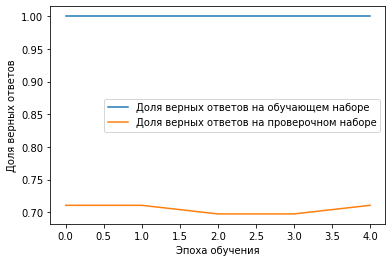

In [81]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## GRU

In [43]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dense(2, activation='sigmoid'))

In [44]:
model_gru.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [45]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           320000    
                                                                 
 gru (GRU)                   (None, 300, 64)           18816     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 348,290
Trainable params: 348,290
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model_gru.h5

In [46]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [63]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=32,
                              validation_split=0.5,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.75000
3/3 [==============================] - 0s 78ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.2190 - val_accuracy: 0.5658
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.75000
3/3 [==============================] - 0s 58ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.2437 - val_accuracy: 0.5658
Epoch 3/5
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.75000
3/3 [==============================] - 0s 46ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.2689 - val_accuracy: 0.5658
Epoch 4/5
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.75000
3/3 [==============================] - 0s 52ms/s

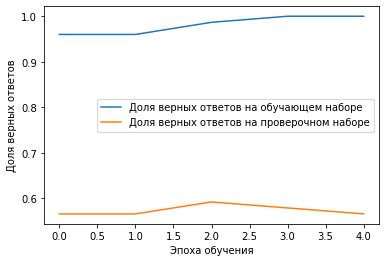

In [51]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сверточная нейронная сеть (CNN)

In [52]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='sigmoid'))

In [53]:
model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [54]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 296, 250)          40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               32128     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 392,636
Trainable params: 392,636
Non-trainable params: 0
________________________________________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [55]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [60]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=32,
                            validation_split=0.5,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.60526
3/3 [==============================] - 0s 35ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.6149 - val_accuracy: 0.6053
Epoch 2/5
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.60526 to 0.61842, saving model to best_model_cnn.h5
3/3 [==============================] - 0s 35ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.6092 - val_accuracy: 0.6184
Epoch 3/5
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.61842
3/3 [==============================] - 0s 27ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.6047 - val_accuracy: 0.6053
Epoch 4/5
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.61842
3/3 [====

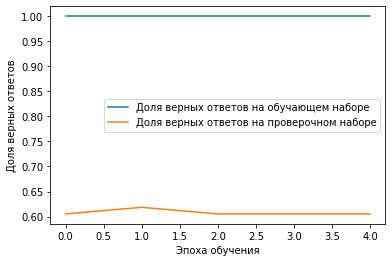

In [64]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Сеть LSTM

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [82]:
model_lstm.load_weights(model_lstm_save_path)

Оцениваем качество работы сети на наборе данных для тестирования

In [83]:
scores = model_lstm.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 0s 18ms/step - loss: 1.0663 - accuracy: 0.6842


In [84]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 68.4211


### Сеть GRU

In [86]:
model_gru.load_weights(model_gru_save_path)

In [87]:
scores = model_gru.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 0s 19ms/step - loss: 0.7701 - accuracy: 0.7368


In [88]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 73.6842


### Одномерная сверточная сеть (CNN)

In [89]:
model_cnn.load_weights(model_cnn_save_path)

In [90]:
scores = model_cnn.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 0s 7ms/step - loss: 0.5991 - accuracy: 0.7632


In [91]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 76.3158


**Оцениваем качество работы сети на новых данных**

In [ ]:
text = ''' President Volodymyr Zelensky of Ukraine said Monday that government officials would be prohibited from traveling abroad for vacation or any other unofficial purpose, a move intended to show that corruption would not be allowed to undermine the country’s defense.'''

Преобразуем новости в числовое представление

In [ ]:
text1 = preprocess(text, stop_words, punctuation_marks, morph)

In [ ]:
text1

['president',
 'volodymyr',
 'zelensky',
 'ukraine',
 'said',
 'monday',
 'government',
 'officials',
 'would',
 'prohibited',
 'traveling',
 'abroad',
 'vacation',
 'unofficial',
 'purpose',
 'move',
 'intended',
 'show',
 'corruption',
 'would',
 'allowed',
 'undermine',
 'country',
 '’',
 'defense']

In [ ]:
sequence = text_to_sequence(text1, word_to_index)

In [ ]:
sequence

[19,
 1541,
 702,
 14,
 5,
 37,
 40,
 47,
 8,
 3033,
 1893,
 1758,
 2644,
 257,
 2585,
 136,
 1389,
 8,
 703,
 23,
 2,
 174]

In [ ]:
print(text)
print(sequence)

 President Volodymyr Zelensky of Ukraine said Monday that government officials would be prohibited from traveling abroad for vacation or any other unofficial purpose, a move intended to show that corruption would not be allowed to undermine the country’s defense.
[19, 1541, 702, 14, 5, 37, 40, 47, 8, 3033, 1893, 1758, 2644, 257, 2585, 136, 1389, 8, 703, 23, 2, 174]


In [ ]:
text2 = pad_sequences(sequence, maxlen=max_news_len)

ValueError: ignored

In [ ]:
text2

NameError: ignored

Загружаем модель в память

In [ ]:
model = load_model('best_model_lstm.h5')

Запускаем распознавание (применяем сеть для определения класса новости)

In [ ]:
prediction = model.predict(text2)

NameError: ignored

Результаты распознавания

In [ ]:
prediction

NameError: ignored

In [ ]:
prediction = np.argmax(prediction)

NameError: ignored

In [ ]:
if prediction < 0.5:
    print('Не имеет международного значения')
else:
    print('Международная новость')

NameError: ignored